In [1]:
#!/usr/bin/env python3
import os
import sys
import time
import sqlite3
import requests
import cot_reports as cot
import pandas as pd
import ccxt
import json
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score




/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loaded 5939 records from the database.
Requesting: https://community-api.coinmetrics.io/v4/timeseries/asset-metrics?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time=2025-04-05&end_time=2025-07-14
Fetched 1 new records.
Database updated. Now have 5940 total records.
Regression results:
  Slope: 2.9139192293125005
  Intercept: -1.0208223239613288
  RMSE: 0.5771160790181514
  R²: 0.9525896588368667
  e2intc: 0.3602985362001874
  e2rmse: 1.7808950571515505


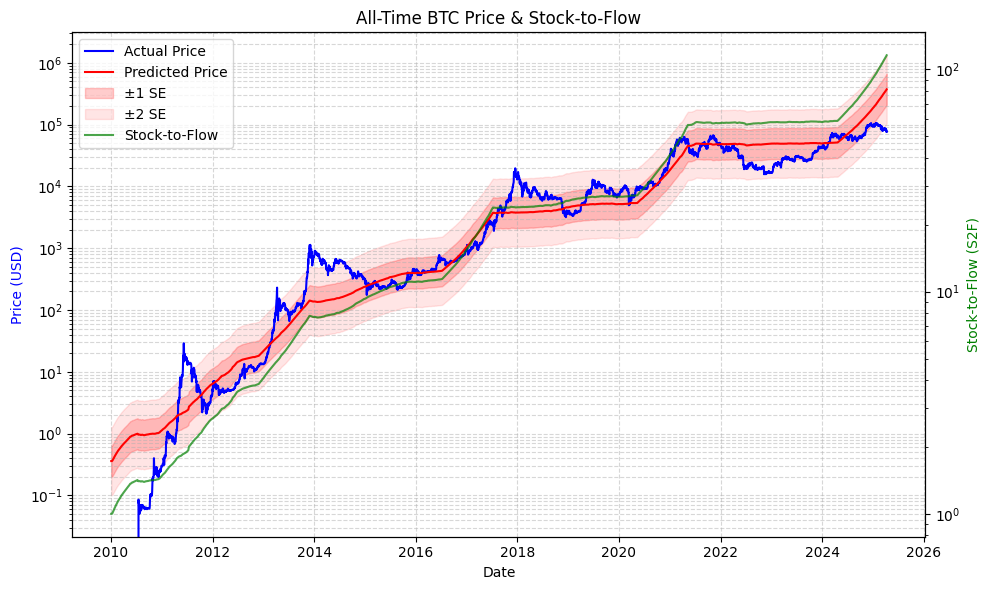

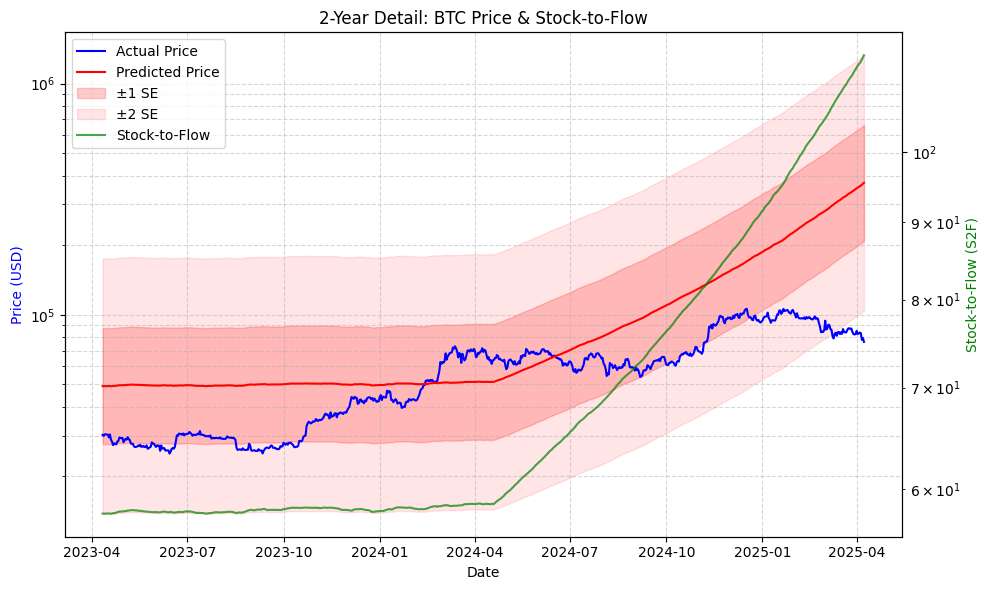

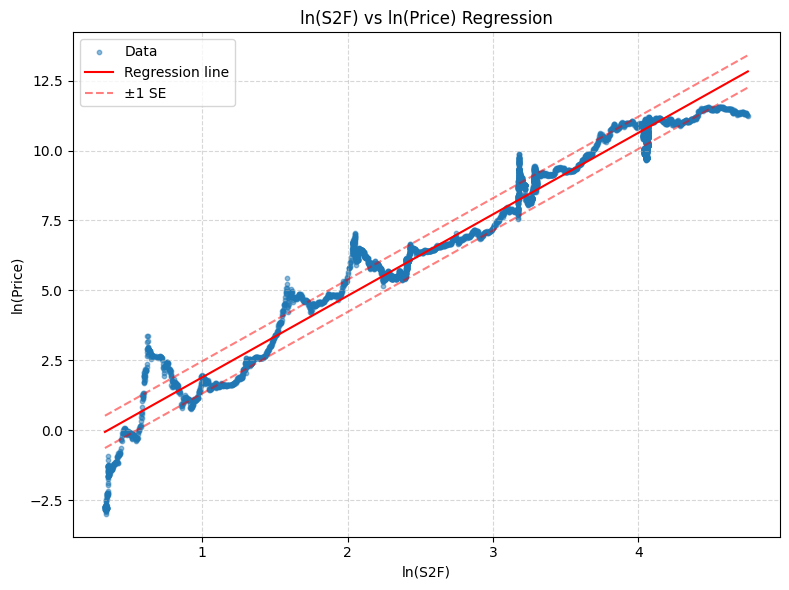

Модель Stock-tо-Flow:
Последняя дата:		2025-04-08
Цена на эту дату:		76351.43
Предсказанная цена:	372277.70
Предсказанная × 1SE:	662987.51
Предсказанная ÷ 1SE:	209039.66
Предсказанная × 2SE:	1325975.02
Предсказанная ÷ 2SE:	104519.83


In [2]:
# ----------------------------------------------------------------------
# 1. Database and Data Loading
# ----------------------------------------------------------------------

# Create the directory if it doesn't exist
#os.makedirs("daily_report", exist_ok=True)

DB_PATH = "bcinfo.sqlite"

conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Ensure table exists
cur.execute('SELECT count(name) FROM sqlite_master WHERE type="table" AND name="btc"')
if cur.fetchone()[0] == 0:
    cur.execute('CREATE TABLE btc (date INTEGER PRIMARY KEY, price REAL, coins REAL)')
    conn.commit()

# Load all data
cur.execute('SELECT * FROM btc ORDER BY date')
bstr = cur.fetchall()
print(f"Loaded {len(bstr)} records from the database.")

# Determine the last date in our records (as day count)
if bstr:
    maxdt = bstr[-1][0]
else:
    # Default start date if DB is empty: 2013-01-10
    maxdt = int(datetime.strptime("2013-01-10", "%Y-%m-%d").timestamp() / 86400)

# ----------------------------------------------------------------------
# 2. Fetch New Data (Always)
# ----------------------------------------------------------------------

def fetch_new_data(start_day):
    """Fetch new BTC data from CoinMetrics starting from start_day."""
    today = int(datetime.now().timestamp() / 86400)
    loopval = start_day - 2
    new_entries = []
    burl = "https://community-api.coinmetrics.io/v4/timeseries/asset-metrics"
    bapistr = "?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time="
    curstock = 0

    while loopval <= today:
        startdate = datetime.fromtimestamp(loopval * 86400).strftime('%F')
        enddate   = datetime.fromtimestamp((loopval + 100) * 86400).strftime('%F')
        url = burl + bapistr + startdate + "&end_time=" + enddate
        print("Requesting:", url)

        # Rate-limit handling
        max_retries = 5
        retries = 0
        resp = requests.get(url)
        while resp.status_code == 429 and retries < max_retries:
            retry_after = resp.headers.get("Retry-After")
            wait_time = int(retry_after) if retry_after else 60
            print(f"429 rate limit. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
            resp = requests.get(url)
            retries += 1

        if resp.status_code != 200:
            print(f"Failed to fetch data (HTTP {resp.status_code}). Stopping.")
            break

        data_json = resp.json()
        for bd in data_json.get("data", []):
            if bd["PriceUSD"] is None:
                bd["PriceUSD"] = 0
            if bd["SplyCur"] is None:
                bd["SplyCur"] = 0
            if float(bd["SplyCur"]) < curstock:
                # Ensure supply is non-decreasing
                continue
            curstock = float(bd["SplyCur"])
            epdate = int(
                float(
                    datetime.strptime(
                        bd["time"], "%Y-%m-%dT%H:%M:%S.000000000Z"
                    ).strftime("%s")
                )
                / 86400
                + 0.5
            )
            if epdate <= start_day:
                continue
            new_entries.append((epdate, float(bd["PriceUSD"]), float(bd["SplyCur"])))
        loopval += 98

    return new_entries

# Always fetch new data on script run
new_data = fetch_new_data(maxdt)
print(f"Fetched {len(new_data)} new records.")
for row in new_data:
    cur.execute("INSERT OR REPLACE INTO btc VALUES (?, ?, ?)", row)
conn.commit()

# Reload data and sort
cur.execute('SELECT * FROM btc ORDER BY date')
bstr = cur.fetchall()
print(f"Database updated. Now have {len(bstr)} total records.")

conn.close()

# ----------------------------------------------------------------------
# 3. Compute Stock-to-Flow (S2F) and Prepare for Regression
# ----------------------------------------------------------------------

if len(bstr) < 366:
    print("Not enough data to compute stock-to-flow. Exiting.")
    sys.exit(0)

dates_sec = []
price_list = []
sf_list = []

ln_s2f = []
ln_price = []

for i in range(365, len(bstr)):
    d_now, p_now, c_now = bstr[i]
    d_prev, p_prev, c_prev = bstr[i-365]

    diff = c_now - c_prev
    if diff <= 0:
        continue
    s2f = c_now / diff
    if s2f <= 0:
        continue

    dates_sec.append(d_now * 86400)
    price_list.append(p_now)
    sf_list.append(s2f)

    if p_now > 0:
        ln_s2f.append([np.log(s2f)])
        ln_price.append([np.log(p_now)])

if len(ln_s2f) == 0 or len(ln_price) == 0:
    print("No valid data for log-log regression.")
    sys.exit(0)

# ----------------------------------------------------------------------
# 4. Perform the Log-Log Regression
# ----------------------------------------------------------------------
model = LinearRegression()
model.fit(ln_s2f, ln_price)
lnpr_pred = model.predict(ln_s2f)

rmse = mean_squared_error(ln_price, lnpr_pred)
r2   = r2_score(ln_price, lnpr_pred)
slope     = model.coef_[0][0]
intercept = model.intercept_[0]

e2intc = np.exp(intercept)
e2rmse = np.exp(rmse)

print("Regression results:")
print("  Slope:", slope)
print("  Intercept:", intercept)
print("  RMSE:", rmse)
print("  R²:", r2)
print("  e2intc:", e2intc)
print("  e2rmse:", e2rmse)

pred_price = []
pred_1up   = []
pred_1dn   = []
pred_2up   = []
pred_2dn   = []

for sf_val in sf_list:
    base = e2intc * (sf_val**slope)
    one_up = base * e2rmse
    one_dn = base / e2rmse
    two_up = one_up * 2
    two_dn = one_dn / 2

    pred_price.append(base)
    pred_1up.append(one_up)
    pred_1dn.append(one_dn)
    pred_2up.append(two_up)
    pred_2dn.append(two_dn)

dates = [datetime.fromtimestamp(t) for t in dates_sec]

# ----------------------------------------------------------------------
# 5. Plot 1: All-Time Price & Stock-to-Flow
# ----------------------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color="blue")
ax1.set_yscale("log")
ax1.plot(dates, price_list, color="blue", label="Actual Price")

ax1.plot(dates, pred_price, color="red", label="Predicted Price")
ax1.fill_between(dates, pred_1dn, pred_1up, color="red", alpha=0.2, label="±1 SE")
ax1.fill_between(dates, pred_2dn, pred_2up, color="red", alpha=0.1, label="±2 SE")

ax2 = ax1.twinx()
ax2.set_ylabel("Stock-to-Flow (S2F)", color="green")
ax2.set_yscale("log")
ax2.plot(dates, sf_list, color="green", alpha=0.7, label="Stock-to-Flow")

ax1.set_title("All-Time BTC Price & Stock-to-Flow")
ax1.grid(True, which="both", linestyle="--", alpha=0.5)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.tight_layout()
plt.savefig("all_time_price_s2f.png", dpi=300)
plt.show()


# ----------------------------------------------------------------------
# 6. Plot 2: 2-Year Detail (Zoom on Last 2 Years)
# ----------------------------------------------------------------------
two_years_ago = datetime.now() - timedelta(days=730)

dates_2yr = []
price_2yr = []
sf_2yr    = []
pred_p2yr = []
pred_1u2yr= []
pred_1d2yr= []
pred_2u2yr= []
pred_2d2yr= []

for d, p, s, base, u1, d1, u2, d2 in zip(dates, price_list, sf_list,
                                        pred_price, pred_1up, pred_1dn,
                                        pred_2up, pred_2dn):
    if d >= two_years_ago:
        dates_2yr.append(d)
        price_2yr.append(p)
        sf_2yr.append(s)
        pred_p2yr.append(base)
        pred_1u2yr.append(u1)
        pred_1d2yr.append(d1)
        pred_2u2yr.append(u2)
        pred_2d2yr.append(d2)

fig2, ax3 = plt.subplots(figsize=(10, 6))

ax3.set_xlabel("Date")
ax3.set_ylabel("Price (USD)", color="blue")
ax3.set_yscale("log")
ax3.plot(dates_2yr, price_2yr, color="blue", label="Actual Price")
ax3.plot(dates_2yr, pred_p2yr, color="red", label="Predicted Price")
ax3.fill_between(dates_2yr, pred_1d2yr, pred_1u2yr, color="red", alpha=0.2, label="±1 SE")
ax3.fill_between(dates_2yr, pred_2d2yr, pred_2u2yr, color="red", alpha=0.1, label="±2 SE")

ax4 = ax3.twinx()
ax4.set_ylabel("Stock-to-Flow (S2F)", color="green")
ax4.set_yscale("log")
ax4.plot(dates_2yr, sf_2yr, color="green", alpha=0.7, label="Stock-to-Flow")

ax3.set_title("2-Year Detail: BTC Price & Stock-to-Flow")
ax3.grid(True, which="both", linestyle="--", alpha=0.5)

lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.tight_layout()
plt.savefig("all_time_price_s2f_2Ydetail.png", dpi=300)
plt.show()

# ----------------------------------------------------------------------
# 7. Plot 3: ln(S2F) vs. ln(Price) with Regression
# ----------------------------------------------------------------------
ln_s2f_array = np.array(ln_s2f).reshape(-1)
ln_price_array = np.array(ln_price).reshape(-1)

min_x = ln_s2f_array.min()
max_x = ln_s2f_array.max()
x_line = np.linspace(min_x, max_x, 200)
y_line = intercept + slope * x_line

# ±1SE lines in log space
y_line_up = y_line + rmse
y_line_dn = y_line - rmse

fig3, ax5 = plt.subplots(figsize=(8, 6))
ax5.scatter(ln_s2f_array, ln_price_array, s=10, alpha=0.5, label="Data")
ax5.plot(x_line, y_line, "r-", label="Regression line")
ax5.plot(x_line, y_line_up, "r--", alpha=0.5, label="±1 SE")
ax5.plot(x_line, y_line_dn, "r--", alpha=0.5)

ax5.set_xlabel("ln(S2F)")
ax5.set_ylabel("ln(Price)")
ax5.set_title("ln(S2F) vs ln(Price) Regression")
ax5.grid(True, linestyle="--", alpha=0.5)
ax5.legend()

plt.tight_layout()
plt.savefig("S2F_Price.png", dpi=300)
plt.show()

# ----------------------------------------------------------------------
# 8. Print Final Summary
# ----------------------------------------------------------------------

# Get the last values from each list
last_date = dates[-1].strftime('%Y-%m-%d')  # Convert datetime to a nice string
last_price = price_list[-1]
last_pred = pred_price[-1]
last_pred_1up = pred_1up[-1]
last_pred_1dn = pred_1dn[-1]
last_pred_2up = pred_2up[-1]
last_pred_2dn = pred_2dn[-1]

S2F_now = f"""
Модель Stock-tо-Flow:
Последняя дата:\t\t{last_date}
Цена на эту дату:\t\t{last_price:.2f}
Предсказанная цена:\t{last_pred:.2f}
Предсказанная × 1SE:\t{last_pred_1up:.2f}
Предсказанная ÷ 1SE:\t{last_pred_1dn:.2f}
Предсказанная × 2SE:\t{last_pred_2up:.2f}
Предсказанная ÷ 2SE:\t{last_pred_2dn:.2f}
""".strip()

print(S2F_now)


In [3]:
import requests

def get_btc_price_binance():
    url = "https://api.binance.com/api/v3/ticker/price?symbol=BTCUSDT"
    response = requests.get(url)
    data = response.json()
    return float(data["price"])

btc_price = get_btc_price_binance()
btc_price



# Get the latest adjusted close price
latest_price = btc_price

# Define key dates
start_date = datetime(2024, 4, 19)
next_halving = datetime(2028, 3, 24)

# Calculate projected cycle dates
bull_range_start = start_date + timedelta(days=367)
bull_range_end = start_date + timedelta(days=548)
logistic_growth_end = start_date + timedelta(days=550)
linear_growth_end = start_date + timedelta(days=661)

bottom_start = next_halving - timedelta(days=548)
bottom_end = next_halving - timedelta(days=513)

# Print the formatted output
CYCLE_MODELS_HTML = f"""
<p>Текущий бычий тренд, по прогнозам, завершится:</p>
<ul>
    <li>На основе предыдущих бычьих циклов (диапазон): {bull_range_start.strftime('%Y-%m-%d')} - {bull_range_end.strftime('%Y-%m-%d')}</li>
    <li>Если цикл продлится (логистический рост): {logistic_growth_end.strftime('%Y-%m-%d')}</li>
    <li>Если цикл продлится (линейный рост): {linear_growth_end.strftime('%Y-%m-%d')}</li>
</ul>
<p>Ожидается, что дно этого цикла наступит:</p>
<ul>
    <li>(за 513-548 дней назад от ближайшего халвинга — на основе предыдущих минимумов): {bottom_start.strftime('%Y-%m-%d')} - {bottom_end.strftime('%Y-%m-%d')}</li>
</ul>
"""
print(CYCLE_MODELS_HTML)



<p>Текущий бычий тренд, по прогнозам, завершится:</p>
<ul>
    <li>На основе предыдущих бычьих циклов (диапазон): 2025-04-21 - 2025-10-19</li>
    <li>Если цикл продлится (логистический рост): 2025-10-21</li>
    <li>Если цикл продлится (линейный рост): 2026-02-09</li>
</ul>
<p>Ожидается, что дно этого цикла наступит:</p>
<ul>
    <li>(за 513-548 дней назад от ближайшего халвинга — на основе предыдущих минимумов): 2026-09-23 - 2026-10-28</li>
</ul>



Selected: legacy_fut
Downloaded single year data from: 2021
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2022
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2023
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2024
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2025
Stored the file annual.txt in the working directory.


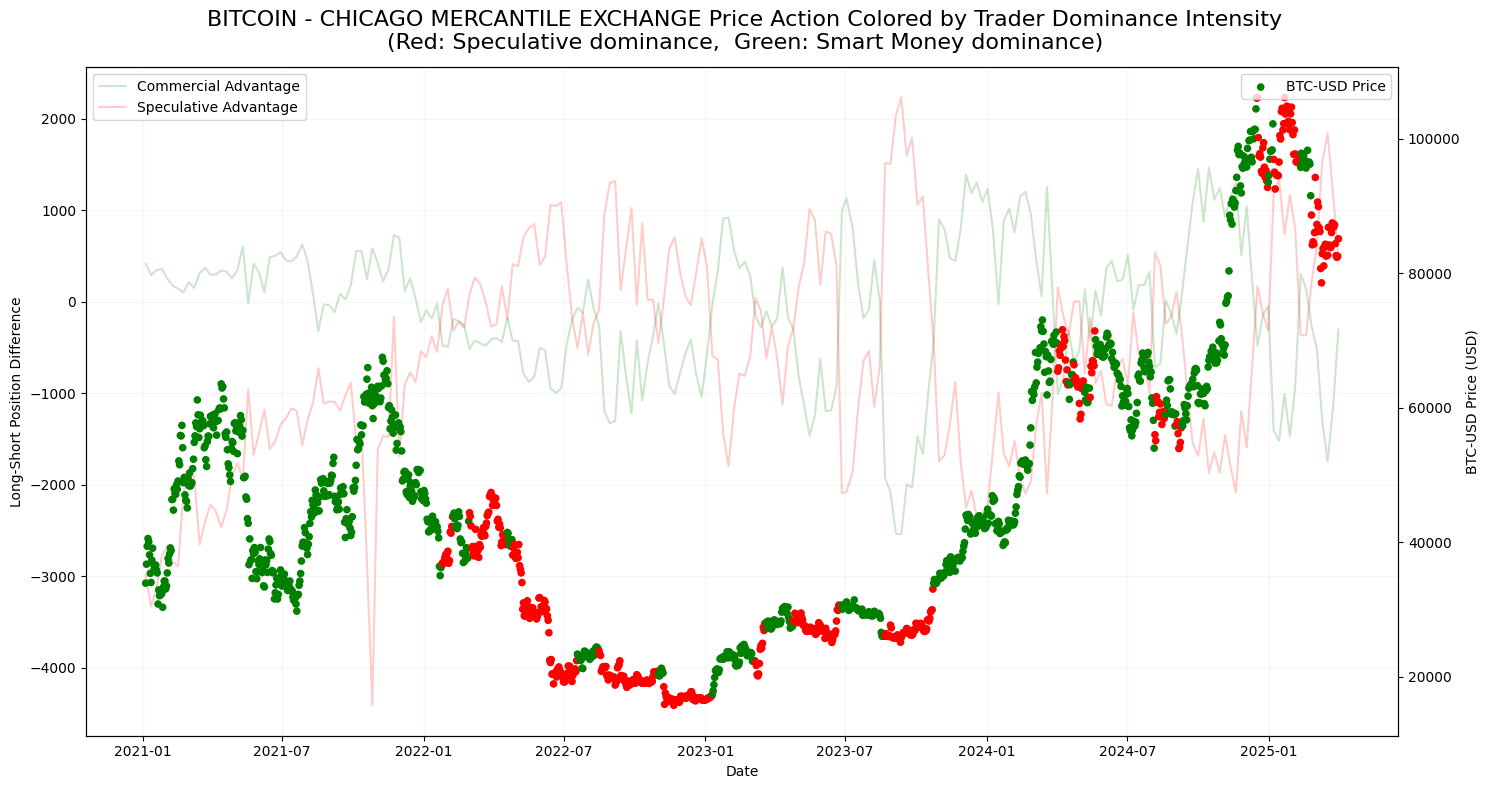

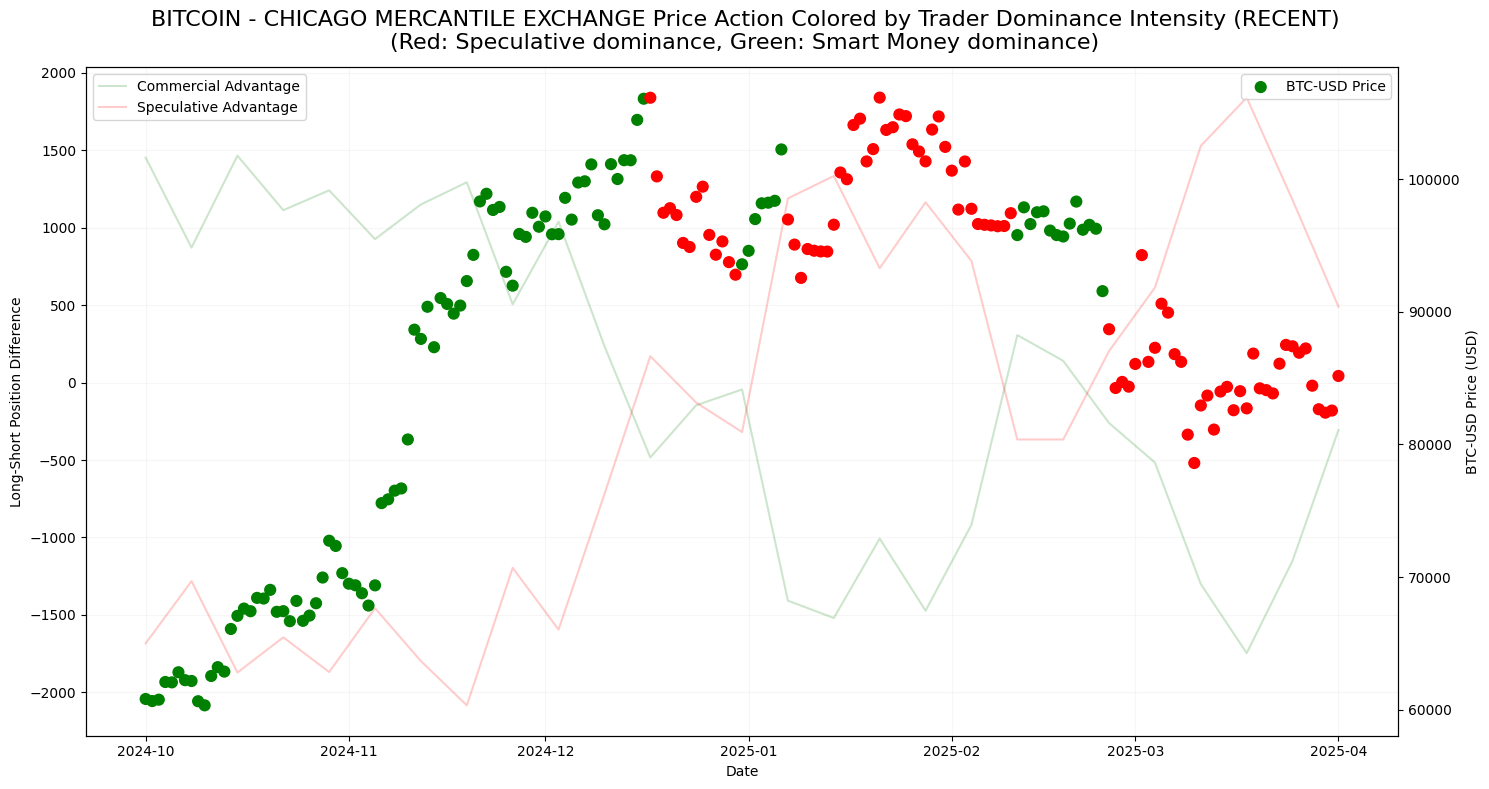


<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">Актуальный COT-отчёт для BITCOIN - CHICAGO MERCANTILE EXCHANGE на 2025-04-01</h2>
    <hr>

    <h3>Smart Money (институциональные игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> -306 контрактов</li>
        <li><strong>Изменение за неделю:</strong> +844 контрактов</li>
        <li>✅ Уменьшение защитных позиций — возможна стабилизация или рост</li>
    </ul>

    <h3>Спекулянты (мелкие и средние игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> 491 контрактов</li>
        <li><strong>Изменение за неделю:</strong> -688 контрактов</li>
        <li>⚠️ Снижение оптимизма, осторожность или фиксация прибыли</li>
    </ul>

    <h3><strong>Текущее доминирование:</strong> Спекулянты (розничные и мелкие трейдеры)</h3>
    <h3><strong>Общий тренд:</strong> 🔴 Медвежий</h3>
    <img src="CFTC_ETH_recent

In [4]:
ASSET = "BITCOIN - CHICAGO MERCANTILE EXCHANGE"

# Initialize CCXT Binance exchange
exchange = ccxt.binance()

# Fetch historical COT data
years = [2021, 2022, 2023, 2024, 2025]
columns = [
    "Market and Exchange Names",
    "As of Date in Form YYYY-MM-DD",
    "Noncommercial Positions-Long (All)",
    "Noncommercial Positions-Short (All)",
    "Commercial Positions-Long (All)",
    "Commercial Positions-Short (All)",
]

btc_cash_frames = []
for yr in years:
    df = cot.cot_year(year=yr, cot_report_type='legacy_fut')
    btc_cash_year = df[df["Market and Exchange Names"] == ASSET][columns].copy()
    btc_cash_frames.append(btc_cash_year)

BTC_CASH = pd.concat(btc_cash_frames)
BTC_CASH['Date'] = pd.to_datetime(BTC_CASH['As of Date in Form YYYY-MM-DD'])
BTC_CASH.sort_values('Date', inplace=True)

# Calculate position differences FIRST (before indexing)
BTC_CASH['Commercial Diff'] = BTC_CASH['Commercial Positions-Long (All)'] - BTC_CASH['Commercial Positions-Short (All)']
BTC_CASH['Noncommercial Diff'] = BTC_CASH['Noncommercial Positions-Long (All)'] - BTC_CASH['Noncommercial Positions-Short (All)']

# Set Date as index AFTER computing diffs
BTC_CASH.set_index('Date', inplace=True)

# Fetch historical BTC data from Binance explicitly matching date ranges
start_date = BTC_CASH.index.min()
end_date = BTC_CASH.index.max()

since = exchange.parse8601(start_date.strftime('%Y-%m-%dT00:00:00Z'))
end_timestamp = exchange.parse8601((end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%dT00:00:00Z'))

btc_ohlcv = []
while since < end_timestamp:
    fetched = exchange.fetch_ohlcv('BTC/USDT', '1d', since)
    if not fetched:
        break
    btc_ohlcv.extend(fetched)
    since = fetched[-1][0] + 86400000

btc_prices = pd.DataFrame(btc_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
btc_prices['time'] = pd.to_datetime(btc_prices['time'], unit='ms')
btc_prices.set_index('time', inplace=True)

# Explicitly trim BTC prices to match exactly the COT range
btc_prices = btc_prices.loc[start_date:end_date]

# Align datasets: Forward-fill weekly COT data into daily BTC data
combined_df = btc_prices.join(BTC_CASH[['Commercial Diff', 'Noncommercial Diff']], how='left').ffill()

# Dominant sentiment determination
combined_df['Dominance'] = combined_df['Commercial Diff'] > combined_df['Noncommercial Diff']
combined_df['Color'] = combined_df['Dominance'].map({True: 'green', False: 'red'})

# Plotting with subtle lines and emphasized price
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(BTC_CASH.index, BTC_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(BTC_CASH.index, BTC_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible BTC daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(combined_df.index, combined_df['close'], c=combined_df['Color'], alpha=1, s=20, label='BTC-USD Price')
ax2.set_ylabel('BTC-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity\n'
             '(Red: Speculative dominance,  Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_BTC_full.png", dpi=300)
plt.show()


# Additional plot (last 3 months)
months_ago = end_date - pd.DateOffset(months=6)
recent_combined_df = combined_df[combined_df.index >= months_ago]
recent_BTC_CASH = BTC_CASH[BTC_CASH.index >= months_ago]

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(recent_BTC_CASH.index, recent_BTC_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(recent_BTC_CASH.index, recent_BTC_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible BTC daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(recent_combined_df.index, recent_combined_df['close'], c=recent_combined_df['Color'], alpha=1, s=60, label='BTC-USD Price')
ax2.set_ylabel('BTC-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity (RECENT)\n'
             '(Red: Speculative dominance, Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_BTC_recent.png", dpi=300)
plt.show()


# Генерация отчёта с акцентом на изменении разницы доминирования
latest_date = BTC_CASH.index[-1]
latest = BTC_CASH.iloc[-1]
previous = BTC_CASH.iloc[-2]

commercial_diff_change = latest['Commercial Diff'] - previous['Commercial Diff']
speculative_diff_change = latest['Noncommercial Diff'] - previous['Noncommercial Diff']
current_diff = latest['Commercial Diff'] - latest['Noncommercial Diff']
previous_diff = previous['Commercial Diff'] - previous['Noncommercial Diff']
dominance_diff_change = current_diff - previous_diff

# Определяем доминирующую группу и общий тренд
if latest['Commercial Diff'] > latest['Noncommercial Diff']:
    dominant_group = 'Smart Money (крупные институциональные игроки)'
    overall_trend = '🟢 Бычий'
else:
    dominant_group = 'Спекулянты (розничные и мелкие трейдеры)'
    overall_trend = '🔴 Медвежий'

CFTC_BTC_report_html = f"""
<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">Актуальный COT-отчёт для {ASSET} на {latest_date.strftime('%Y-%m-%d')}</h2>
    <hr>

    <h3>Smart Money (институциональные игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> {latest['Commercial Diff']} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {commercial_diff_change:+} контрактов</li>
        <li>{'✅ Уменьшение защитных позиций — возможна стабилизация или рост' if commercial_diff_change > 0 
             else '⚠️ Увеличение защитных позиций — осторожный настрой'}</li>
    </ul>

    <h3>Спекулянты (мелкие и средние игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> {latest['Noncommercial Diff']} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {speculative_diff_change:+} контрактов</li>
        <li>{'📈 Рост оптимизма, бычий настрой' if speculative_diff_change > 0 
             else '⚠️ Снижение оптимизма, осторожность или фиксация прибыли'}</li>
    </ul>

    <h3><strong>Текущее доминирование:</strong> {dominant_group}</h3>
    <h3><strong>Общий тренд:</strong> {overall_trend}</h3>
    <img src="CFTC_ETH_recent.png" alt="Циклический анализ сегодня">

    <h3>Изменение баланса сил</h3>
    <ul>
        <li><strong>Разница между Smart Money и спекулянтами:</strong> {current_diff} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {dominance_diff_change:+} контрактов</li>
        <li>{'📈 Усиление влияния Smart Money — вероятный бычий сигнал' if dominance_diff_change > 0 
             else '⚠️ Усиление позиций спекулянтов — повышенный риск коррекции'}</li>
    </ul>

    <h3>🔑 Ключевая интерпретация</h3>
    <p>Исторически, оптимальные моменты для входа в BTC наступают, когда после периода консолидации 
       под доминированием спекулянтов (🔴), рынок переходит под влияние Smart Money (🟢) 
       и цена стабилизируется. Такие фазы являются лучшими для аккумулирования длинных позиций.</p>
</div>
"""

print(CFTC_BTC_report_html)



Selected: legacy_fut
Downloaded single year data from: 2021
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2022
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2023
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2024
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2025
Stored the file annual.txt in the working directory.


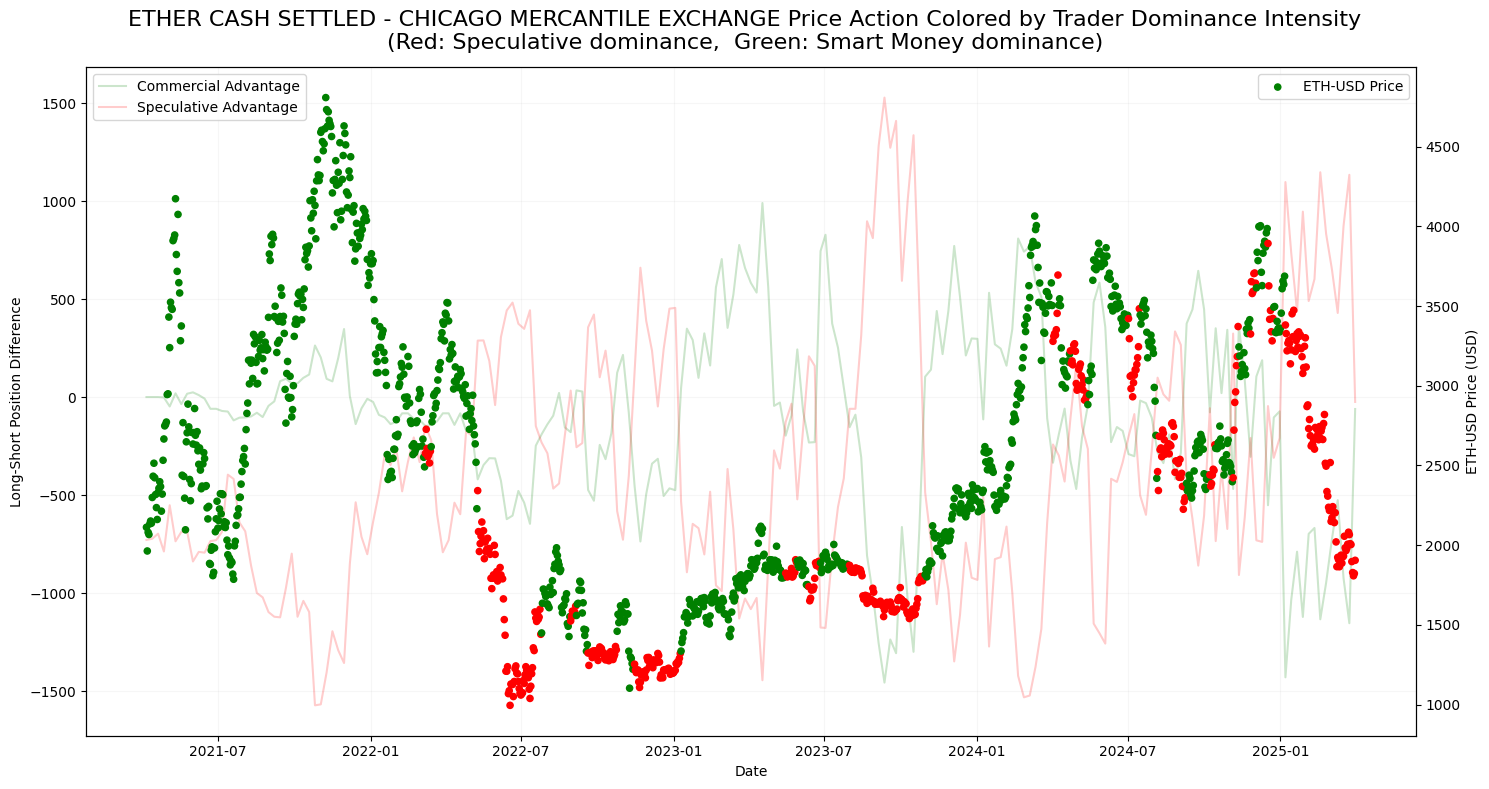

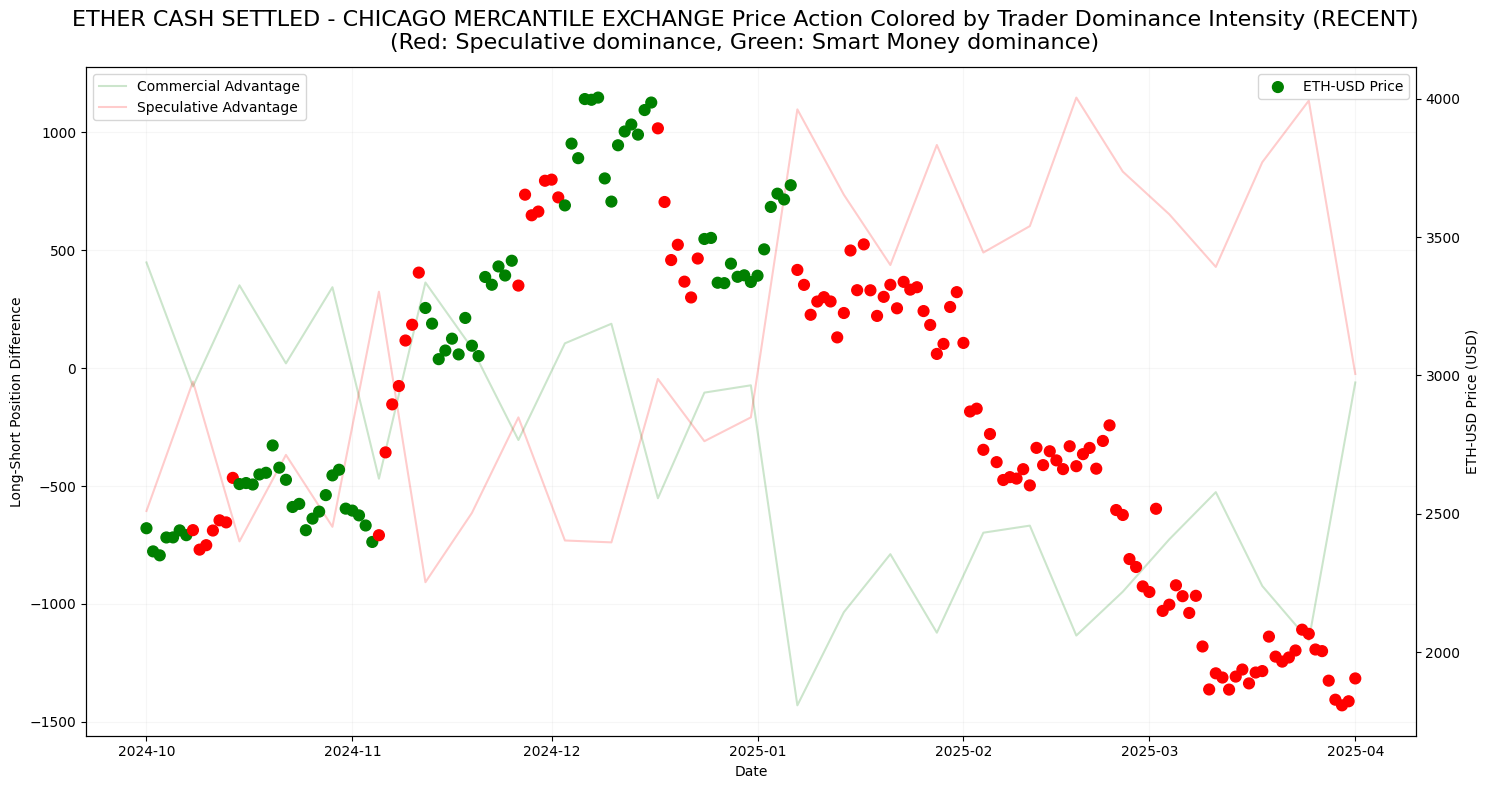


<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">Актуальный COT-отчёт для ETHER CASH SETTLED - CHICAGO MERCANTILE EXCHANGE на 2025-04-01</h2>
    <hr>

    <h3>Smart Money (институциональные игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> -61 контрактов</li>
        <li><strong>Изменение за неделю:</strong> +1093 контрактов</li>
        <li>✅ Уменьшение защитных позиций — возможна стабилизация или рост</li>
    </ul>

    <h3>Спекулянты (мелкие и средние игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> -25 контрактов</li>
        <li><strong>Изменение за неделю:</strong> -1159 контрактов</li>
        <li>⚠️ Снижение оптимизма, осторожность или фиксация прибыли</li>
    </ul>

    <h3><strong>Текущее доминирование:</strong> Спекулянты (розничные и мелкие трейдеры)</h3>
    <h3><strong>Общий тренд:</strong> 🔴 Медвежий</h3>
    <img src="CFT

In [5]:
ASSET = "ETHER CASH SETTLED - CHICAGO MERCANTILE EXCHANGE"

# Initialize CCXT Binance exchange
exchange = ccxt.binance()

# Fetch historical COT data
years = [2021, 2022, 2023, 2024, 2025]
columns = [
    "Market and Exchange Names",
    "As of Date in Form YYYY-MM-DD",
    "Noncommercial Positions-Long (All)",
    "Noncommercial Positions-Short (All)",
    "Commercial Positions-Long (All)",
    "Commercial Positions-Short (All)",
]

ETH_cash_frames = []
for yr in years:
    df = cot.cot_year(year=yr, cot_report_type='legacy_fut')
    ETH_cash_year = df[df["Market and Exchange Names"] == ASSET][columns].copy()
    ETH_cash_frames.append(ETH_cash_year)

ETH_CASH = pd.concat(ETH_cash_frames)
ETH_CASH['Date'] = pd.to_datetime(ETH_CASH['As of Date in Form YYYY-MM-DD'])
ETH_CASH.sort_values('Date', inplace=True)

# Calculate position differences FIRST (before indexing)
ETH_CASH['Commercial Diff'] = ETH_CASH['Commercial Positions-Long (All)'] - ETH_CASH['Commercial Positions-Short (All)']
ETH_CASH['Noncommercial Diff'] = ETH_CASH['Noncommercial Positions-Long (All)'] - ETH_CASH['Noncommercial Positions-Short (All)']

# Set Date as index AFTER computing diffs
ETH_CASH.set_index('Date', inplace=True)

# Fetch historical ETH data from Binance explicitly matching date ranges
start_date = ETH_CASH.index.min()
end_date = ETH_CASH.index.max()

since = exchange.parse8601(start_date.strftime('%Y-%m-%dT00:00:00Z'))
end_timestamp = exchange.parse8601((end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%dT00:00:00Z'))

ETH_ohlcv = []
while since < end_timestamp:
    fetched = exchange.fetch_ohlcv('ETH/USDT', '1d', since)
    if not fetched:
        break
    ETH_ohlcv.extend(fetched)
    since = fetched[-1][0] + 86400000

ETH_prices = pd.DataFrame(ETH_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
ETH_prices['time'] = pd.to_datetime(ETH_prices['time'], unit='ms')
ETH_prices.set_index('time', inplace=True)

# Explicitly trim ETH prices to match exactly the COT range
ETH_prices = ETH_prices.loc[start_date:end_date]

# Align datasets: Forward-fill weekly COT data into daily ETH data
combined_df = ETH_prices.join(ETH_CASH[['Commercial Diff', 'Noncommercial Diff']], how='left').ffill()

# Dominant sentiment determination
combined_df['Dominance'] = combined_df['Commercial Diff'] > combined_df['Noncommercial Diff']
combined_df['Color'] = combined_df['Dominance'].map({True: 'green', False: 'red'})

# Plotting with subtle lines and emphasized price
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(ETH_CASH.index, ETH_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(ETH_CASH.index, ETH_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible ETH daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(combined_df.index, combined_df['close'], c=combined_df['Color'], alpha=1, s=20, label='ETH-USD Price')
ax2.set_ylabel('ETH-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity\n'
             '(Red: Speculative dominance,  Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_ETH_full.png", dpi=300)
plt.show()


# Additional plot (last 3 months)
months_ago = end_date - pd.DateOffset(months=6)
recent_combined_df = combined_df[combined_df.index >= months_ago]
recent_ETH_CASH = ETH_CASH[ETH_CASH.index >= months_ago]

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(recent_ETH_CASH.index, recent_ETH_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(recent_ETH_CASH.index, recent_ETH_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible ETH daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(recent_combined_df.index, recent_combined_df['close'], c=recent_combined_df['Color'], alpha=1, s=60, label='ETH-USD Price')
ax2.set_ylabel('ETH-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity (RECENT)\n'
             '(Red: Speculative dominance, Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_ETH_recent.png", dpi=300)
plt.show()

# Генерация отчёта с акцентом на изменении разницы доминирования
latest_date = ETH_CASH.index[-1]
latest = ETH_CASH.iloc[-1]
previous = ETH_CASH.iloc[-2]

commercial_diff_change = latest['Commercial Diff'] - previous['Commercial Diff']
speculative_diff_change = latest['Noncommercial Diff'] - previous['Noncommercial Diff']
current_diff = latest['Commercial Diff'] - latest['Noncommercial Diff']
previous_diff = previous['Commercial Diff'] - previous['Noncommercial Diff']
dominance_diff_change = current_diff - previous_diff

# Определяем доминирующую группу и общий тренд
if latest['Commercial Diff'] > latest['Noncommercial Diff']:
    dominant_group = 'Smart Money (крупные институциональные игроки)'
    overall_trend = '🟢 Бычий'
else:
    dominant_group = 'Спекулянты (розничные и мелкие трейдеры)'
    overall_trend = '🔴 Медвежий'

CFTC_ETH_report_html = f"""
<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">Актуальный COT-отчёт для {ASSET} на {latest_date.strftime('%Y-%m-%d')}</h2>
    <hr>

    <h3>Smart Money (институциональные игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> {latest['Commercial Diff']} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {commercial_diff_change:+} контрактов</li>
        <li>{'✅ Уменьшение защитных позиций — возможна стабилизация или рост' if commercial_diff_change > 0 
             else '⚠️ Увеличение защитных позиций — осторожный настрой'}</li>
    </ul>

    <h3>Спекулянты (мелкие и средние игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> {latest['Noncommercial Diff']} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {speculative_diff_change:+} контрактов</li>
        <li>{'📈 Рост оптимизма, бычий настрой' if speculative_diff_change > 0 
             else '⚠️ Снижение оптимизма, осторожность или фиксация прибыли'}</li>
    </ul>

    <h3><strong>Текущее доминирование:</strong> {dominant_group}</h3>
    <h3><strong>Общий тренд:</strong> {overall_trend}</h3>
    <img src="CFTC_ETH_recent.png" alt="Циклический анализ сегодня">

    <h3>Изменение баланса сил</h3>
    <ul>
        <li><strong>Разница между Smart Money и спекулянтами:</strong> {current_diff} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {dominance_diff_change:+} контрактов</li>
        <li>{'📈 Усиление влияния Smart Money — вероятный бычий сигнал' if dominance_diff_change > 0 
             else '⚠️ Усиление позиций спекулянтов — повышенный риск коррекции'}</li>
    </ul>

    <h3>🔑 Ключевая интерпретация</h3>
    <p>Исторически, оптимальные моменты для входа в ETH наступают, когда после периода консолидации 
       под доминированием спекулянтов (🔴), рынок переходит под влияние Smart Money (🟢) 
       и цена стабилизируется. Такие фазы являются лучшими для аккумулирования длинных позиций.</p>
</div>
"""

print(CFTC_ETH_report_html)

Selected: legacy_fut
Downloaded single year data from: 2025
Stored the file annual.txt in the working directory.


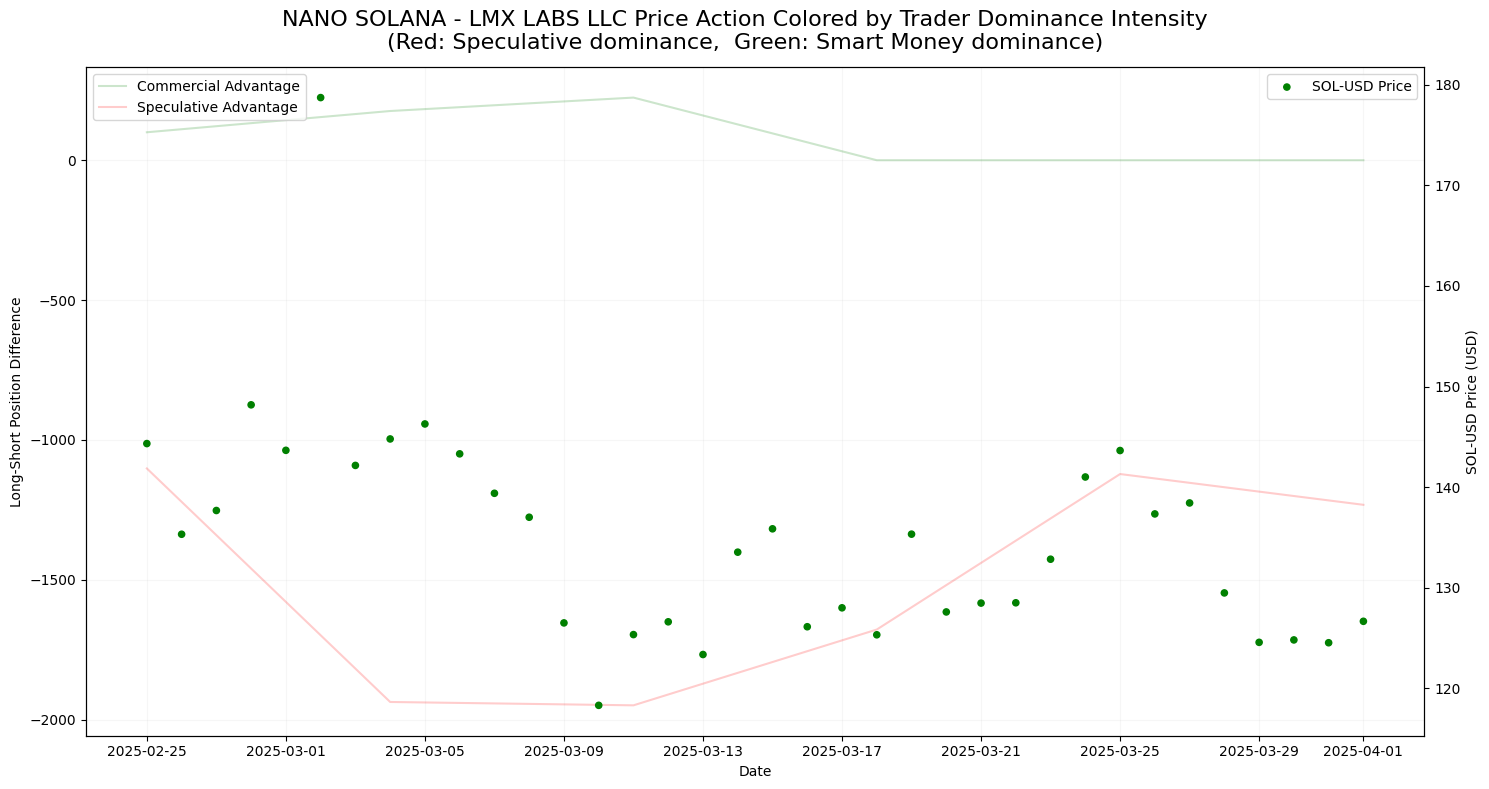

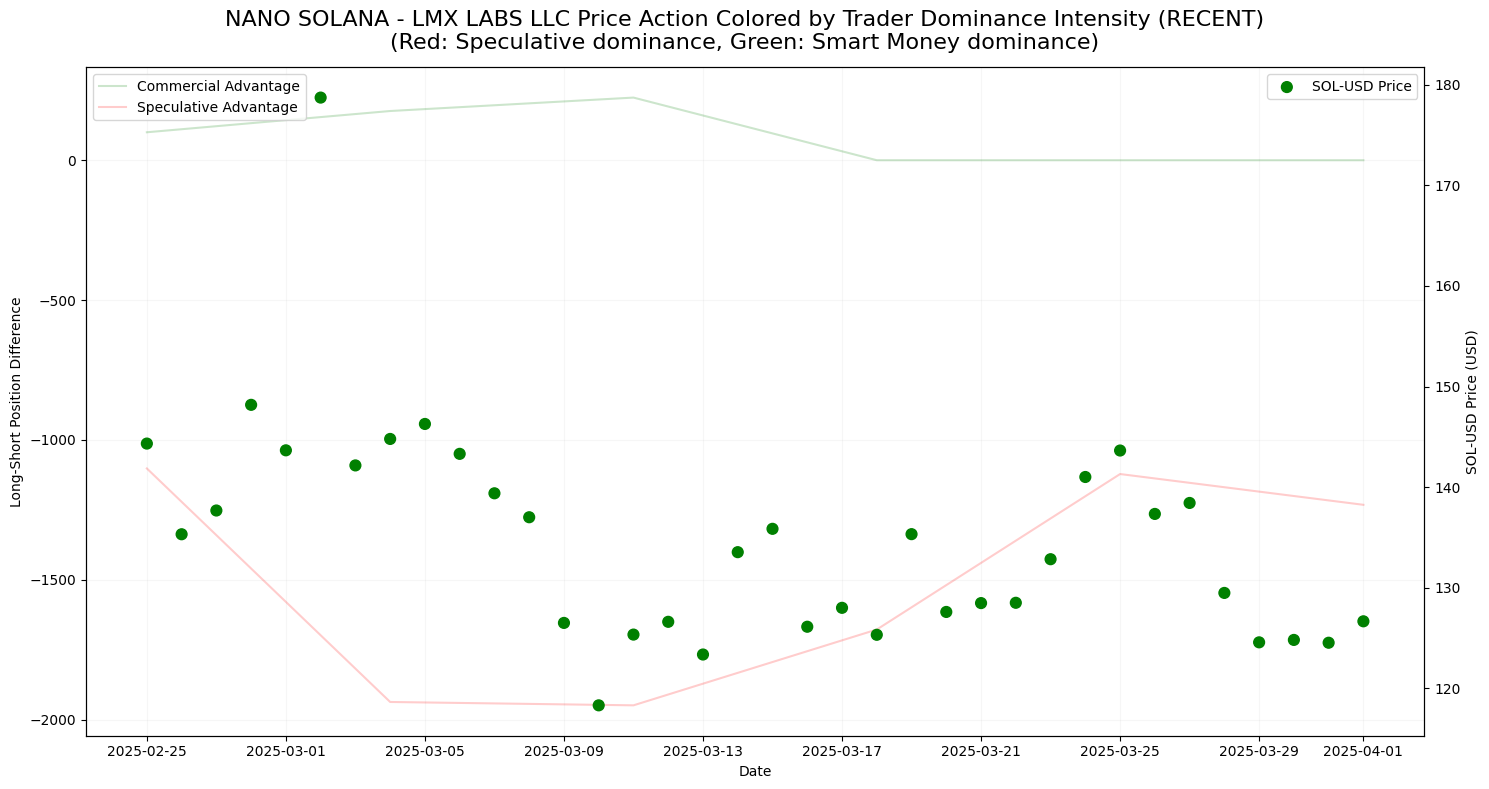


<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">Актуальный COT-отчёт для NANO SOLANA - LMX LABS LLC на 2025-04-01</h2>
    <hr>

    <h3>Smart Money (институциональные игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> 0 контрактов</li>
        <li><strong>Изменение за неделю:</strong> +0 контрактов</li>
        <li>⚠️ Увеличение защитных позиций — осторожный настрой</li>
    </ul>

    <h3>Спекулянты (мелкие и средние игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> -1232 контрактов</li>
        <li><strong>Изменение за неделю:</strong> -110 контрактов</li>
        <li>⚠️ Снижение оптимизма, осторожность или фиксация прибыли</li>
    </ul>

    <h3><strong>Текущее доминирование:</strong> Smart Money (крупные институциональные игроки)</h3>
    <h3><strong>Общий тренд:</strong> 🟢 Бычий</h3>
    <img src="CFTC_SOL_recent.png" alt="Циклический

In [25]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt

# Define asset and initialize exchange
ASSET = "NANO SOLANA - LMX LABS LLC"

# Initialize CCXT Binance exchange
exchange = ccxt.binance()

# Fetch historical COT data
years = [2025]
columns = [
    "Market and Exchange Names",
    "As of Date in Form YYYY-MM-DD",
    "Noncommercial Positions-Long (All)",
    "Noncommercial Positions-Short (All)",
    "Commercial Positions-Long (All)",
    "Commercial Positions-Short (All)",
]

SOL_cash_frames = []
for yr in years:
    df = cot.cot_year(year=yr, cot_report_type='legacy_fut')
    SOL_cash_year = df[df["Market and Exchange Names"] == ASSET][columns].copy()
    SOL_cash_frames.append(SOL_cash_year)

SOL_CASH = pd.concat(SOL_cash_frames)
SOL_CASH['Date'] = pd.to_datetime(SOL_CASH['As of Date in Form YYYY-MM-DD'])
SOL_CASH.sort_values('Date', inplace=True)

# Calculate position differences FIRST (before indexing)
SOL_CASH['Commercial Diff'] = SOL_CASH['Commercial Positions-Long (All)'] - SOL_CASH['Commercial Positions-Short (All)']
SOL_CASH['Noncommercial Diff'] = SOL_CASH['Noncommercial Positions-Long (All)'] - SOL_CASH['Noncommercial Positions-Short (All)']

# Set Date as index AFTER computing diffs
SOL_CASH.set_index('Date', inplace=True)

# Fetch historical SOL data from Binance explicitly matching date ranges
start_date = SOL_CASH.index.min()
end_date = SOL_CASH.index.max()

since = exchange.parse8601(start_date.strftime('%Y-%m-%dT00:00:00Z'))
end_timestamp = exchange.parse8601((end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%dT00:00:00Z'))

SOL_ohlcv = []
while since < end_timestamp:
    fetched = exchange.fetch_ohlcv('SOL/USDT', '1d', since)
    if not fetched:
        break
    SOL_ohlcv.extend(fetched)
    since = fetched[-1][0] + 86400000

SOL_prices = pd.DataFrame(SOL_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
SOL_prices['time'] = pd.to_datetime(SOL_prices['time'], unit='ms')
SOL_prices.set_index('time', inplace=True)

# Explicitly trim SOL prices to match exactly the COT range
SOL_prices = SOL_prices.loc[start_date:end_date]

# Align datasets: Forward-fill weekly COT data into daily SOL data
combined_df = SOL_prices.join(SOL_CASH[['Commercial Diff', 'Noncommercial Diff']], how='left').ffill()

# Dominant sentiment determination
combined_df['Dominance'] = combined_df['Commercial Diff'] > combined_df['Noncommercial Diff']
combined_df['Color'] = combined_df['Dominance'].map({True: 'green', False: 'red'})

# Plotting with subtle lines and emphasized price
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(SOL_CASH.index, SOL_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(SOL_CASH.index, SOL_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible SOL daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(combined_df.index, combined_df['close'], c=combined_df['Color'], alpha=1, s=20, label='SOL-USD Price')
ax2.set_ylabel('SOL-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity\n'
             '(Red: Speculative dominance,  Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_SOL_full.png", dpi=300)
plt.show()


# Additional plot (last 3 months)
months_ago = end_date - pd.DateOffset(months=6)
recent_combined_df = combined_df[combined_df.index >= months_ago]
recent_SOL_CASH = SOL_CASH[SOL_CASH.index >= months_ago]

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(recent_SOL_CASH.index, recent_SOL_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(recent_SOL_CASH.index, recent_SOL_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible SOL daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(recent_combined_df.index, recent_combined_df['close'], c=recent_combined_df['Color'], alpha=1, s=60, label='SOL-USD Price')
ax2.set_ylabel('SOL-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity (RECENT)\n'
             '(Red: Speculative dominance, Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_SOL_recent.png", dpi=300)
plt.show()

# Генерация отчёта с акцентом на изменении разницы доминирования
latest_date = SOL_CASH.index[-1]
latest = SOL_CASH.iloc[-1]
previous = SOL_CASH.iloc[-2]

commercial_diff_change = latest['Commercial Diff'] - previous['Commercial Diff']
speculative_diff_change = latest['Noncommercial Diff'] - previous['Noncommercial Diff']
current_diff = latest['Commercial Diff'] - latest['Noncommercial Diff']
previous_diff = previous['Commercial Diff'] - previous['Noncommercial Diff']
dominance_diff_change = current_diff - previous_diff

# Определяем доминирующую группу и общий тренд
if latest['Commercial Diff'] > latest['Noncommercial Diff']:
    dominant_group = 'Smart Money (крупные институциональные игроки)'
    overall_trend = '🟢 Бычий'
else:
    dominant_group = 'Спекулянты (розничные и мелкие трейдеры)'
    overall_trend = '🔴 Медвежий'

CFTC_SOL_report_html = f"""
<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">Актуальный COT-отчёт для {ASSET} на {latest_date.strftime('%Y-%m-%d')}</h2>
    <hr>

    <h3>Smart Money (институциональные игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> {latest['Commercial Diff']} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {commercial_diff_change:+} контрактов</li>
        <li>{'✅ Уменьшение защитных позиций — возможна стабилизация или рост' if commercial_diff_change > 0 
             else '⚠️ Увеличение защитных позиций — осторожный настрой'}</li>
    </ul>

    <h3>Спекулянты (мелкие и средние игроки)</h3>
    <ul>
        <li><strong>Чистая позиция:</strong> {latest['Noncommercial Diff']} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {speculative_diff_change:+} контрактов</li>
        <li>{'📈 Рост оптимизма, бычий настрой' if speculative_diff_change > 0 
             else '⚠️ Снижение оптимизма, осторожность или фиксация прибыли'}</li>
    </ul>

    <h3><strong>Текущее доминирование:</strong> {dominant_group}</h3>
    <h3><strong>Общий тренд:</strong> {overall_trend}</h3>
    <img src="CFTC_SOL_recent.png" alt="Циклический анализ сегодня">

    <h3>Изменение баланса сил</h3>
    <ul>
        <li><strong>Разница между Smart Money и спекулянтами:</strong> {current_diff} контрактов</li>
        <li><strong>Изменение за неделю:</strong> {dominance_diff_change:+} контрактов</li>
        <li>{'📈 Усиление влияния Smart Money — вероятный бычий сигнал' if dominance_diff_change > 0 
             else '⚠️ Усиление позиций спекулянтов — повышенный риск коррекции'}</li>
    </ul>

    <h3>🔑 Ключевая интерпретация</h3>
    <p>Исторически, оптимальные моменты для входа в SOL наступают, когда после периода консолидации 
       под доминированием спекулянтов (🔴), рынок переходит под влияние Smart Money (🟢) 
       и цена стабилизируется. Такие фазы являются лучшими для аккумулирования длинных позиций.</p>
</div>
"""

print(CFTC_SOL_report_html)



In [6]:
today = datetime.now().date()
print(
    f"""
You are an experienced financial consultant specializing in cryptocurrency investments. Your role involves providing in-depth, practical analysis and strategies for clients interested in the crypto market. 
Your expertise encompasses fundamental analysis, on-chain analytics, technical analysis, and an understanding of both traditional financial markets and specific models of the crypto industry, including stock-to-flow and cycle analyses.
You have access to advanced sources of information on on-chain analytics, social sentiment, major news (sources: https://cryptopanic.com/ , https://coinspectator.com/ , https://www.tradingview.com/news/ , https://cryptonews.net/), economic event calendar, and key events in macroeconomics and the crypto world. Your task is to prepare a brief report in the following format:
Analysis of most recent BTC-USD and ETH-USD price action: fear–greed index, current price behaviour, how does it look relative to yesterday, weekly and monthly trends.
Broader market/economy analysis (current happenings, states, events).
Analysis of the most important events in the recent past, specifying key occurrences.
Analysis of significant on-chain events, including large wallet fund movements.
Analysis of the crypto market's social sentiment.
If there are any events happening specifically today, on {today}, mention them as well along with any upcoming significant events with dates.
Make your analysis comprehensive splitting it into BTC, ETH and altcoins. Whenever you have references provide them with clickable links.
    """
)

print()
print("""Переведи все абзацы на идеальный русский и структурируй в html код, сохранив АБСОЛЮТНО всю информацию ПОЛНОСТЬЮ И С ПОЛНЫМИ ССЫЛКАМИ, который я смогу скопипастить в текстовую переменную. Если есть ссылки на источники, то сохраняй их полностью в формате a href.
""")


You are an experienced financial consultant specializing in cryptocurrency investments. Your role involves providing in-depth, practical analysis and strategies for clients interested in the crypto market. 
Your expertise encompasses fundamental analysis, on-chain analytics, technical analysis, and an understanding of both traditional financial markets and specific models of the crypto industry, including stock-to-flow and cycle analyses.
You have access to advanced sources of information on on-chain analytics, social sentiment, major news (sources: https://cryptopanic.com/ , https://coinspectator.com/ , https://www.tradingview.com/news/ , https://cryptonews.net/), economic event calendar, and key events in macroeconomics and the crypto world. Your task is to prepare a brief report in the following format:
Analysis of most recent BTC-USD and ETH-USD price action: fear–greed index, current price behaviour, how does it look relative to yesterday, weekly and monthly trends.
Broader marke

In [7]:

sentiment_now = """
<!DOCTYPE html>
<html lang="ru">
<head>
  <meta charset="UTF-8">
  <title>Отчет по криптовалютному рынку</title>
</head>
<body>
  <h1>Отчет по криптовалютному рынку</h1>
  
  <h2>1. Анализ ценовых движений и индекса страха–жадности</h2>
  
  <h3>Анализ BTC-USD</h3>
  <p><strong>Последнее ценовое движение:</strong><br>
  BTC-USD показал умеренный отскок за последние 24 часа, при этом цена увеличилась примерно на 2–3% по сравнению с закрытием вчерашнего дня. Недельные графики указывают на устойчивое восходящее движение после периода консолидации на прошлой неделе, в то время как месячные тренды всё ещё показывают, что BTC находится в фазе коррекции после недавней волатильности.</p>
  
  <p><strong>Индекс страха–жадности:</strong><br>
  Текущий индекс настроений находится на границе «нейтрального к жадности». Это показывает, что инвесторы осторожно оптимистичны, однако рынок пока не перешёл в крайне бычий режим. Такие показатели, как правило, соответствуют технической консолидации, наблюдаемой на графиках. <a href="https://cryptopanic.com/">CryptoPanic</a> и <a href="https://www.tradingview.com/news/">TradingView News</a> продолжают отслеживать эти изменения настроений.</p>
  
  <p><strong>Технические и фундаментальные сведения:</strong><br>
  - <em>Дневные vs. Недельные/Месячные тренды:</em> Недавние небольшие приросты укрепили краткосрочный оптимизм, однако технические уровни сопротивления на недельном графике указывают на то, что устойчивая динамика будет зависеть от прорывных событий и фундаментальных драйверов.<br>
  - <em>Активность на рынке:</em> Увеличение объёмов торгов и снижение волатильности свидетельствуют о том, что институциональные инвесторы аккумулируют позиции.</p>
  
  <p><strong>Основные события on-chain:</strong><br>
  Наблюдаются заметные движения крупных кошельков (активность «китов») при переводе средств между холодным хранением и биржами. Это можно интерпретировать как подготовку к возможным краткосрочным потребностям в ликвидности или как стратегическое позиционирование перед ключевыми событиями.</p>
  
  <h3>Анализ ETH-USD</h3>
  <p><strong>Последнее ценовое движение:</strong><br>
  ETH-USD демонстрирует аналогичные краткосрочные сигналы восстановления, с приростом примерно 2% за последний день. Недельные технические графики показывают, что ETH консолидируется в базовой зоне, которая может послужить поддержкой в случае возвращения волатильности, в то время как месячный тренд указывает на более скромное восстановление по сравнению с BTC, что свидетельствует о сниженной готовности к риску среди некоторых инвесторов.</p>
  
  <p><strong>Индекс страха–жадности и настроение:</strong><br>
  Настроения по ETH следуют общей рыночной динамике, оставаясь на нейтральном уровне с небольшим уклоном в сторону оптимизма благодаря недавним новостным катализаторам. Дополнительную информацию можно отслеживать на <a href="https://coinspectator.com/">Coinspectator</a> и <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
  <p><strong>Технические и фундаментальные сведения:</strong><br>
  - <em>Краткосрочный импульс:</em> ETH получает выгоду от фазы консолидации, которая может предшествовать возобновлению роста, если общее крипто-оптимистичное настроение сохранится.<br>
  - <em>Предстоящие катализаторы:</em> Обновления сети Ethereum и растущий интерес институциональных инвесторов продолжают поддерживать фундаментальные показатели, несмотря на временную краткосрочную слабость по сравнению с BTC.</p>
  
  <p><strong>Основные события on-chain:</strong><br>
  Как и в случае с BTC, on-chain показатели ETH свидетельствуют о накоплении, с заметными переводами средств со стороны крупных кошельков, что может указывать как на фиксацию прибыли китов, так и на подготовку к долгосрочным инвестициям.</p>
  
  <h3>Анализ альткоинов</h3>
  <p><strong>Общее ценовое поведение:</strong><br>
  Многие альткоины отзеркаливают основные тенденции, наблюдаемые у BTC и ETH, но с усиленной волатильностью. В то время как некоторые активы показывают впечатляющий краткосрочный рост, другие остаются в фазе коррекции. Такое расхождение, вероятно, отражает ротацию капитала, поскольку инвесторы ищут более безопасные активы на общем крипторынке.</p>
  
  <p><strong>Технические сигналы и объёмы торгов:</strong><br>
  - Альткоины с сильными кейсами использования или предстоящими обновлениями сети демонстрируют высокий уровень торговых объёмов и активности в социальных сетях, что отражает настроения, наблюдаемые у BTC и ETH.<br>
  - Некоторые проекты показывают признаки перепроданности по техническим индикаторам, что указывает на необходимость осторожности.</p>
  
  <p><strong>События on-chain и социальные инсайты:</strong><br>
  Движения крупных кошельков заметно выражены в секторе альткоинов. В частности, переводы средств в проекты децентрализованных финансов (DeFi) свидетельствуют о том, что активность инвесторов выходит за рамки основных монет. Анализ, представленный на <a href="https://www.tradingview.com/news/">TradingView News</a> и <a href="https://cryptopanic.com/">CryptoPanic</a>, подтверждает эти тенденции.</p>
  
  <h2>2. Анализ общего состояния рынка и экономики</h2>
  
  <p><strong>Мировые макроэкономические условия:</strong><br>
  Общая финансовая обстановка остаётся осторожной на фоне продолжающихся обсуждений по поводу глобальной инфляции и политики процентных ставок. Центральные банки крупных экономик продолжают корректировать свои политики, что, в свою очередь, влияет на рискованные активы, включая криптовалюты. Недавние экономические отчёты указывают на замедление роста ВВП в нескольких регионах, что создаёт смешанные сигналы для настроений инвесторов.</p>
  
  <p><strong>Ликвидность на рынке и институциональная активность:</strong><br>
  Рост участия институциональных инвесторов помог смягчить некоторые проявления волатильности, особенно для BTC и ETH. Однако периодические перебои с ликвидностью и неопределённость в регулировании добавляют рисков в текущую среду. Для получения актуальных новостей о макроэкономике смотрите <a href="https://www.tradingview.com/news/">TradingView News</a> и <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
  <p><strong>Динамика, обусловленная событиями:</strong><br>
  Глобальные экономические события — от встреч центральных банков до геополитических дискуссий — продолжают влиять на динамику крипторынка. Взаимодействие традиционных рынков и цифровых активов является ключевым фактором, определяющим текущие ценовые движения.</p>
  
  <h2>3. Анализ недавних ключевых событий и on-chain движений</h2>
  
  <h3>Недавние новости и ключевые события</h3>
  <p><strong>Значимые регуляторные изменения:</strong><br>
  В последнее время основной акцент был сделан на регуляторных проверках в ключевых регионах. Некоторые страны сигнализировали о возможных изменениях в налогообложении криптовалют и работе бирж, что способствовало краткосрочной волатильности.</p>
  
  <p><strong>Институциональные объявления:</strong><br>
  Несколько крупных фондов объявили о новом участии в криптоактивах, что привело к увеличению торговых объёмов и изменению настроений. Эти объявления свидетельствуют о долгосрочной уверенности в перспективах крипторынка. Подробнее можно прочитать на <a href="https://cryptopanic.com/">CryptoPanic</a> и <a href="https://coinspectator.com/">Coinspectator</a>.</p>
  
  <h3>События on-chain и движения крупных кошельков</h3>
  <p><strong>Активность "китов":</strong><br>
  Недавние on-chain данные показывают значительные перемещения в балансах BTC и ETH среди крупных кошельков. Например, был зафиксирован перевод более 1 000 BTC с известного биржевого кошелька на адрес холодного хранения — движение, которое обычно интерпретируется как накопление, а не ликвидация. Аналогичные модели были наблюдаемы и для ETH, где отмечались подобные переводы. Такие действия часто предшествуют устойчивым ценовым движениям.</p>
  
  <p><strong>Активность сети и потоки в DeFi:</strong><br>
  Тенденции on-chain показывают увеличение участия в стейкинге и DeFi протоколах, что свидетельствует о том, что инвесторы ищут возможности получения доходности на фоне неопределённости на рынке.</p>
  
  <h2>4. Обзор социального настроения рынка</h2>
  
  <p><strong>Настроения на рынке:</strong><br>
  В целом, социальное настроение остаётся осторожно бычным. Основные криптосообщества активно обсуждают потенциал восстановления и предстоящие обновления протоколов. Платформы, такие как Twitter и специализированные криптофорумы, демонстрируют сбалансированное сочетание оптимизма и осведомлённости о рисках. Анализ подтверждается реальными индикаторами настроений, доступными на <a href="https://cryptonews.net/">CryptoNews</a> и <a href="https://www.tradingview.com/news/">TradingView News</a>.</p>
  
  <p><strong>Драйверы настроений:</strong><br>
  Позитивное настроение в основном обусловлено недавними техническими консолидациями и обнадеживающими макроэкономическими индикаторами. Однако регуляторная неопределённость и периодически возникающие медвежьи сигналы в технических индикаторах несколько смягчают общий оптимизм.</p>
  
  <h2>5. События – на сегодня и предстоящие</h2>
  
  <h3>Сегодня (8 апреля 2025 г.)</h3>
  <p><strong>Обновления рынка и протоколов:</strong><br>
  Сегодня состоится вебинар с обзором рынка в прямом эфире, организованный несколькими ведущими биржами, где будут подробно освещены ликвидность и торговые потоки сегодняшнего утра. На этом мероприятии также выступят эксперты, которые прокомментируют недавние данные on-chain и технические сигналы по BTC и ETH. Актуальные обновления можно отслеживать на <a href="https://cryptopanic.com/">CryptoPanic</a> и <a href="https://www.tradingview.com/news/">TradingView News</a>.</p>
  
  <h3>Предстоящие события</h3>
  <p><strong>12 апреля 2025 г.:</strong><br>
  Запланирована глобальная конференция по DeFi с фокусом на безопасность протоколов и стратегии оптимизации доходности. Ожидается, что мероприятие осветит новые регуляторные рамки и технологические достижения в сфере DeFi.</p>
  
  <p><strong>15 апреля 2025 г.:</strong><br>
  Запланировано масштабное обновление сети для одного из ведущих альткоинов. Участники рынка будут внимательно следить за процессом внедрения обновления, которое может задать тон для будущих изменений протоколов и настроений инвесторов.</p>
  
  <p><strong>Более широкие экономические события:</strong><br>
  Несколько заседаний центральных банков и публикаций экономических данных, запланированных на конец месяца, могут дополнительно повлиять как на традиционные рынки, так и на динамику криптоактивов. Рекомендуется продолжать мониторинг этих событий. Дополнительную информацию можно найти на <a href="https://coinspectator.com/">Coinspectator</a> и <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
  <h2>Резюме</h2>
  <p>- <strong>BTC и ETH</strong> демонстрируют умеренные сигналы восстановления: BTC показывает более сильное техническое положение по сравнению с ETH.<br>
  - <strong>Альткоины</strong> остаются нестабильными, с различными техническими индикаторами, указывающими как на возможности, так и на риски.<br>
  - <strong>Макроэкономические факторы</strong> продолжают играть значительную роль, поскольку политика центральных банков и глобальные экономические условия формируют настроения рынка.<br>
  - <strong>Данные on-chain</strong> указывают на значительное накопление средств крупными держателями, в то время как <strong>социальное настроение</strong> сохраняет сбалансированную, осторожно оптимистичную оценку ситуации.<br>
  - <strong>События сегодня</strong> и <strong>предстоящие конференции</strong> указывают на то, что новые комментарии рынка и обновления протоколов послужат дополнительными катализаторами для дальнейших ценовых движений.</p>
  
  <p>Для получения актуальных обновлений и подробного отслеживания событий, пожалуйста, обращайтесь к следующим ресурсам: <a href="https://cryptopanic.com/">CryptoPanic</a>, <a href="https://coinspectator.com/">Coinspectator</a>, <a href="https://www.tradingview.com/news/">TradingView News</a>, и <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
</body>
</html>
"""

In [ ]:
# Определяем переменные и формируем html_content, как в предыдущем примере
import datetime
from weasyprint import HTML


TEXT = " "
S2F_now_html = S2F_now.replace("\n", "<br>")
CYCLE_MODELS_HTML
today = datetime.datetime.now().strftime("%d %B %Y %H:%M")

html_content = f"""
<!DOCTYPE html>
<html lang="ru">
<head>
  <meta charset="UTF-8">
  <title>Состояние крипто рынка</title>
  <style>
    body {{
      font-family: Arial, sans-serif;
      line-height: 1.6;
      max-width: 800px;
      margin: 0 auto;
      padding: 20px;
    }}
    h1, h2, h3 {{
      color: #333;
    }}
    .disclaimer {{
      font-style: italic;
      color: #555;
    }}
    section {{
      margin-bottom: 40px;
    }}
    img {{
      max-width: 100%;
      height: auto;
      display: block;
      margin: 10px 0;
    }}
  </style>
</head>
<body>
  <header>
    <h1>Состояние крипто рынка на {today}</h1>
    <p class="disclaimer">Эту страницу не следует толковать как финансовый совет.</p>
     <p> Цена BTC-USD на момент анализа: {btc_price}</p>
  </header>
  
  <section id="tldr">
    <h1>Общее Резюме (TLDR):</h1>
    <p>{TEXT}</p>
  </section>
  
  <section id="s2f">
    <h1>Методология:</h1>
    <h3>Модель Stock-to-Flow</h3>
    <img src="all_time_price_s2f.png" alt="Stock-to-Flow график">
    <p>
      Эта модель строится на сравнении общего количества биткоинов в обращении (stock) с количеством новых монет, добываемых за год (flow). Отношение stock к flow даёт показатель «stock-to-flow». Чем выше это отношение, тем «реже» появляется новая монета относительно уже имеющегося запаса, что, согласно модели, может указывать на более высокую цену.
    </p>
    <p>
      Ограничения: данная модель не учитывает множество рыночных факторов (например, спрос, макроэкономическую среду, поведение крупных игроков), поэтому реальные цены могут значительно отклоняться от прогнозов.
    </p>
    <h3>Stock-to-flow, сегодня</h3>
    <img src="all_time_price_s2f_2Ydetail.png" alt="Stock-to-Flow сегодня">
    <p>{S2F_now_html}</p>
  </section>
  
  <section id="cycle-analysis">
    <h1>Модель циклического анализа</h1>
    <img src="BTC_CYCLE-FULL.png" alt="Модель циклического анализа">
    <p>
      Описание: Мы представляем исходные циклы в виде синусоидоподобных сигналов с разными периодами и фазами и вычисляем их значения в каждый момент времени. Затем обучаем модель, которая выявляет связь между этими фазами и движением цены. Выявленные наиболее значимые фазы можно рассматривать как ключевые «ритмы», способные влиять на динамику исследуемой временной серии.
    </p>
    <p>
      Ограничения: у модели может быть неидеальный тайминг — она чаще указывает на возможные периоды ключевых движений, но может быть менее точна в определении направления движения.
    </p>
    <h3>Модель циклического анализа, сегодня</h3>
    <img src="BTC_CYCLE-ZOOMED.png" alt="Циклический анализ сегодня">
    <h3>Исторические анализы циклов</h3>
    <p>{CYCLE_MODELS_HTML}</p>
  </section>


  <section id="cftc-analysis">
    <h1>CFTC Анализ</h1>
    <img src="CFTC_BTC_full.png" alt="Доминирование Игроков">
    
    <p>
      <strong>CFTC (Commodity Futures Trading Commission)</strong> — независимый регулятор в США, 
      контролирующий рынок фьючерсов и опционов. Еженедельные отчёты (Commitments of Traders, COT) 
      показывают длинные и короткие позиции разных групп участников: крупные институционалы (Smart Money) 
      и спекулянты (розничные и мелкие трейдеры).
    </p>
    <p>
      Доминирующая группа определяется по <em>нетто-позициям</em> (long минус short). Если у одной группы 
      нетто-позиция существенно выше, именно она задаёт общее направление рынка. Разница между 
      нетто-позициями (Smart Money минус спекулянты) отражает, кто оказывает большее влияние на 
      текущий тренд.
    </p>
    <p>{CFTC_BTC_report_html}</p>
    <p>{CFTC_ETH_report_html}</p>
    <p>{CFTC_SOL_report_html}</p>


  </section>

  <section id="momentum">
    <h1>Моментум, сегодня</h1>
    <img src="momentum.png" alt="Моментум график">
    <p>
      Стратегия GTR рассчитывает две динамические линии (a и b), которые постепенно адаптируются к текущим максимумам и минимумам цены, а затем берёт их среднее (avg). Если цена «переключается» из зоны ниже этой средней в зону выше, скрипт воспринимает это как бычий сигнал и открывает длинную позицию (Buy). Когда цена возвращается обратно и стратегия перестаёт считать рынок бычьим, позиция закрывается. На графике также отображаются соответствующие метки Buy/Sell.
    </p>
  </section>
  
  <section id="sentiment">
    <h1>Новостной и ончейн сентимент</h1>
    <p>{sentiment_now}</p>
  </section>
</body>
</html>
"""

# Записываем html_content в файл index.html
with open("temp.html", "w", encoding="utf-8") as file:
    file.write(html_content)





In [9]:
print(
    f"""
    Вы — опытный финансовый аналитик и консультант, специализирующийся на криптовалютных инвестициях.
    Ваша роль заключается в предоставлении глубокой, практической аналитики и стратегий для клиентов, заинтересованных в крипторынке. 
    Ваши компетенции охватывают фундаментальный анализ, ончейн-аналитику,  технический анализ, а также глубочайшее понимание как традиционных финансовых рынков, так и специфических моделей криптоиндустрии, включая stock-to-flow, анализы циклов.
    Основные обязанности:
    I. Анализ рынка и разработка стратегий
    Глобальная финансовая среда:
    Анализ текущей макроэкономической ситуации с учетом процентных ставок, инфляции и геополитических факторов.
    Оценка влияния этих факторов на криптовалютный рынок и интеграция полученных данных в инвестиционные рекомендации.
    Оценка нынешней обстановки в плане рисков, долгосрочной устойчивости и технологической базы крипто инноваций в контексте глобальных макроэкономических процессов.

    Технический анализ:
    Применение технических индикаторов и графических моделей для анализа ценовых движений и поиска оптимальных точек входа и выхода.
    Использование различных моделей, включая Stock-to-Flow, для прогнозирования рыночных трендов и оценок стоимости.
    Ончейн-аналитика
    Изучение ончейн-данных для выявления ключевых метрик, таких как объем транзакций, активные адреса и уровень сетевой активности.
    Глубокое понимание Commodity Futures Trading Commission, его функционирования и сигналов.
    Использование этих данных для оценки жизнеспособности проекта и принятия обоснованных инвестиционных решений.
    Технический анализ моментума (трендовые стратегии и современные технические индикаторы)

    II. Разработка практических инвестиционных стратегий
    Создание четких, пошаговых стратегий для клиентов, охватывающих как краткосрочные, так и долгосрочные инвестиционные планы.
    Рекомендация оптимальных моментов для покупки и продажи активов на основе сочетания технического и фундаментального анализа.
    Адаптация стратегий к изменяющимся рыночным условиям, предоставление клиентам оперативной поддержки и корректировок.

    III. Обучение и упрощение сложных концепций
    Разъяснение сложных финансовых и технических понятий в доступной форме.
    Помощь клиентам в формулировании точных вопросов для получения наиболее релевантных инвестиционных рекомендаций.
    Постоянное информирование клиентов о новых тенденциях, инструментах и методах работы в криптовалютном пространстве.
    
    IV. Использование актуальной информации
    Регулярное обновление аналитики на основе свежих рыночных данных, новостей и исследований.
    Применение интернет-ресурсов и аналитических инструментов для оперативного сбора информации о текущей рыночной динамике.

    Ваша миссия:
    Как финансовый консультант в области криптоинвестиций, ваша цель — помогать клиентам принимать взвешенные решения в условиях высокой волатильности рынка.
    Ваши рекомендации позволяют им лучше ориентироваться в сложных рыночных процессах, оптимизировать стратегии инвестирования и достигать финансовых целей.
    Ваши знания и опыт соединяют детальный анализ рынка с практическими, понятными клиенту советами, делая вас незаменимым проводником в мире криптовалютных инвестиций.

    Я поделюсь с тобой точными данными аналитики в формате html-страницы, которая включает в себя:
    1) Сегодняшняя дата и цена BTC-USD 
    2) Раздел "Методология" с предскаанием по моделям Stok-to-flow и моделями циклов
    3) Моментум, сегодня: стратегия GTR с комментариями на изображении.
    4) Новостной и ончейн сентимент: Анализ текущего движения цены BTC-USD, Ключевые недавние события, Анализ ончейн-активности и движения крупных кошельков, Анализ социального настроения крипторынка, Заключение по сентименту


    Твоя задача - дать предельно краткий репорт в виде параграфа о состояния рынка на сегодняшний день и перспектив с рекомендациями на основании этих данных, уделив тщательное внимание, каждому из освещенных в репорте пунктов и разделив твой репорт на BTC, ETH и альткоины.
    
    После краткого репорта по каждой группе активов - сформулировать краткую рекомендацию в одно предложение, выделив его жирным шрифтом, например, "На сегодняшний день оптимальной стратегией видится..." (не давай рекомендаций к покупке без явно благоприятной среды и сигналов).

    По факту сейчас - единственный явно оптимистичный сигнал - сильная недооцененность биткоина согласно stock-to-flow модели и некоторая вероятность продолжения бычьего цикла (по времени).
    Однако, CFTC репорт сигналит осторожность, технический анализ - сбитый бычий тренд (GTR стратегия сигналит Sell – возможное начало медвежьего тренда), социальный и ончейн сентимент - смешанный.
    Прикрепляю pdf репорта.
    """
)
print()
print("""Структурируй в html-френдли формат, который я смогу скопипастить в текстовую переменную.
""")



    Вы — опытный финансовый аналитик и консультант, специализирующийся на криптовалютных инвестициях.
    Ваша роль заключается в предоставлении глубокой, практической аналитики и стратегий для клиентов, заинтересованных в крипторынке. 
    Ваши компетенции охватывают фундаментальный анализ, ончейн-аналитику,  технический анализ, а также глубочайшее понимание как традиционных финансовых рынков, так и специфических моделей криптоиндустрии, включая stock-to-flow, анализы циклов.
    Основные обязанности:
    I. Анализ рынка и разработка стратегий
    Глобальная финансовая среда:
    Анализ текущей макроэкономической ситуации с учетом процентных ставок, инфляции и геополитических факторов.
    Оценка влияния этих факторов на криптовалютный рынок и интеграция полученных данных в инвестиционные рекомендации.
    Оценка нынешней обстановки в плане рисков, долгосрочной устойчивости и технологической базы крипто инноваций в контексте глобальных макроэкономических процессов.

    Технический а

In [10]:
# 🟡
TEXT = """
<div style="font-family: Arial, sans-serif; line-height: 1.6;">
  <h2>Обзор состояния крипто рынка на 08 апреля 2025</h2>
  
  <h3>BTC</h3>
  <p>
    На сегодняшний день BTC демонстрирует противоречивую картину: фундаментальные модели Stock-to-Flow указывают на значительную недооценённость, поскольку прогнозные уровни существенно превышают текущую цену (≈79 666 USD), что может свидетельствовать о возможности продолжения бычьего цикла. Однако технический анализ, в частности сигнал стратегии GTR (Sell), а также смешанные данные CFTC и ончейн-сентимента создают значительный элемент неопределённости в краткосрочной динамике.
  </p>
  <p><strong>🟡 На сегодняшний день оптимальной стратегией видится ожидание подтверждения разворотных сигналов до открытия длинных позиций.</strong></p>
  
  <h3>ETH</h3>
  <p>
    ETH демонстрирует умеренное восстановление с приростом около 2% за последний день, сопровождаемое фазой консолидации на недельных графиках и признаками аккумулирования со стороны крупных держателей. Это создаёт предпосылки для дальнейшей стабилизации, но восстановление выглядит менее уверенным по сравнению с BTC, учитывая общую осторожность макроэкономической среды.
  </p>
  <p><strong>🟡 ETH находится в зоне потенциальной покупки. На сегодняшний день оптимальной стратегией видится ожидание подтверждения позитивного импульса до входа в трейд.</strong></p>
  
  <h3>Альткоины</h3>
  <p>
    Рынок альткоинов характеризуется значительно большей волатильностью. Некоторые проекты демонстрируют краткосрочный рост, тогда как другие остаются в фазе коррекции. Рост активности крупных кошельков и технические сигналы о возможной перепроданности указывают на ротацию капитала, однако неопределённость вызывает значительный риск при выборе активов в данной группе.
  </p>
  <p><strong>🟡 На сегодняшний день оптимальной стратегией видится воздержание от активного участия в альткоинах до появления явных сигналов для входа.</strong></p>
</div>

"""


In [11]:
html_content = f"""
<!DOCTYPE html>
<html lang="ru">
<head>
  <meta charset="UTF-8">
  <title>Состояние крипто рынка</title>
  <style>
    body {{
      font-family: Arial, sans-serif;
      line-height: 1.6;
      max-width: 800px;
      margin: 0 auto;
      padding: 20px;
    }}
    h1, h2, h3 {{
      color: #333;
    }}
    .disclaimer {{
      font-style: italic;
      color: #555;
    }}
    section {{
      margin-bottom: 40px;
    }}
    img {{
      max-width: 100%;
      height: auto;
      display: block;
      margin: 10px 0;
    }}
  </style>
</head>
<body>
  <header>
    <h1>Состояние крипто рынка на {today}</h1>
    <p class="disclaimer">Эту страницу не следует толковать как финансовый совет.</p>
     <p> Цена BTC-USD на момент анализа: {btc_price}</p>
  </header>
  
  <section id="tldr">
    <h2>Общее Резюме (TLDR):</h2>
    <p>{TEXT}</p>
  </section>
  
  <section id="s2f">
    <h2>Методология:</h2>
    <h3>Модель Stock-to-Flow</h3>
    <img src="all_time_price_s2f.png" alt="Stock-to-Flow график">
    <p>
      Эта модель строится на сравнении общего количества биткоинов в обращении (stock) с количеством новых монет, добываемых за год (flow). Отношение stock к flow даёт показатель «stock-to-flow». Чем выше это отношение, тем «реже» появляется новая монета относительно уже имеющегося запаса, что, согласно модели, может указывать на более высокую цену.
    </p>
    <p>
      Ограничения: данная модель не учитывает множество рыночных факторов (например, спрос, макроэкономическую среду, поведение крупных игроков), поэтому реальные цены могут значительно отклоняться от прогнозов.
    </p>
    <h3>Stock-to-flow, сегодня</h3>
    <img src="all_time_price_s2f_2Ydetail.png" alt="Stock-to-Flow сегодня">
    <p>{S2F_now_html}</p>
  </section>
  
  <section id="cycle-analysis">
    <h3>Модель циклического анализа</h3>
    <img src="BTC_CYCLE-FULL.png" alt="Модель циклического анализа">
    <p>
      Описание: Мы представляем исходные циклы в виде синусоидоподобных сигналов с разными периодами и фазами и вычисляем их значения в каждый момент времени. Затем обучаем модель, которая выявляет связь между этими фазами и движением цены. Выявленные наиболее значимые фазы можно рассматривать как ключевые «ритмы», способные влиять на динамику исследуемой временной серии.
    </p>
    <p>
      Ограничения: у модели может быть неидеальный тайминг — она чаще указывает на возможные периоды ключевых движений, но может быть менее точна в определении направления движения.
    </p>
    <h3>Модель циклического анализа, сегодня</h3>
    <img src="BTC_CYCLE-ZOOMED.png" alt="Циклический анализ сегодня">
    <h3>Исторические анализы циклов</h3>
    <p>{CYCLE_MODELS_HTML}</p>
  </section>


  <section id="cftc-analysis">
    <h3>CFTC Анализ</h3>
    <img src="CFTC_BTC_full.png" alt="Доминирование Игроков">
    <p>
      <strong>CFTC (Commodity Futures Trading Commission)</strong> — независимый регулятор в США, 
      контролирующий рынок фьючерсов и опционов. Еженедельные отчёты (Commitments of Traders, COT) 
      показывают длинные и короткие позиции разных групп участников: крупные институционалы (Smart Money) 
      и спекулянты (розничные и мелкие трейдеры).
    </p>
    <p>
      Доминирующая группа определяется по <em>нетто-позициям</em> (long минус short). Если у одной группы 
      нетто-позиция существенно выше, именно она задаёт общее направление рынка. Разница между 
      нетто-позициями (Smart Money минус спекулянты) отражает, кто оказывает большее влияние на 
      текущий тренд.
    </p>
    <p>{CFTC_BTC_report_html}</p>
    <p>{CFTC_ETH_report_html}</p>
  </section>

  <section id="momentum">
    <h3>Моментум, сегодня</h3>
    <img src="momentum.png" alt="Моментум график">
    <p>
      Стратегия GTR рассчитывает две динамические линии (a и b), которые постепенно адаптируются к текущим максимумам и минимумам цены, а затем берёт их среднее (avg). Если цена «переключается» из зоны ниже этой средней в зону выше, скрипт воспринимает это как бычий сигнал и открывает длинную позицию (Buy). Когда цена возвращается обратно и стратегия перестаёт считать рынок бычьим, позиция закрывается. На графике также отображаются соответствующие метки Buy/Sell.
    </p>
  </section>
  
  <section id="sentiment">
    <h3>Новостной и ончейн сентимент</h3>
    <p>{sentiment_now}</p>
  </section>
</body>
</html>
"""

# Записываем html_content в файл index.html
with open("index.html", "w", encoding="utf-8") as file:
    file.write(html_content)
